In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
PATH_TO_DATA = '/home/marius/Jülich/COSY Beamtime spring 2018/Degrader_Divergenz_SImulation_PZ/'

### data preparation

In [4]:
df1 = pd.DataFrame()

for dir_name in os.listdir(PATH_TO_DATA):
    
    filenames = os.listdir(os.path.join(PATH_TO_DATA, dir_name))
    momentum = [s for s in filenames if 'AngleMomentum' in s]
    for file in momentum:
        
        df_temp = pd.read_table(os.path.join(PATH_TO_DATA, dir_name, file),
                                header = None,
                                names = ['angle', 'counts'],
                                delim_whitespace = True
                               )
        
        df_temp['E_init'] = int(dir_name.split('->')[0].strip(dir_name[0]))
        df_temp['E_final'] = int(dir_name.split('->')[1])
        df_temp['particle'] = dir_name[0]
        df_temp['variable'] = file[-1]
        df_temp['mrads'] = 1e3*2*np.pi*df_temp['angle'] / 360
    
        df1 = df1.append(df_temp)

In [5]:
df1.head()

,angle,counts,E_init,E_final,particle,variable,mrads
0,-58.803843,1.0,76,10,D,X,-1026.320666
1,-58.703843,0.0,76,10,D,X,-1024.575336
2,-58.603843,0.0,76,10,D,X,-1022.830007
3,-58.503843,0.0,76,10,D,X,-1021.084678
4,-58.403843,0.0,76,10,D,X,-1019.339349


### fitting divergences

In [6]:
# gauss function
def gaussian(x,M,std2,a):
    return a * np.exp(-(x-M)**2 / (2*std2))

In [7]:
# twiss parameters
beta = {'X': 10, 'Y': 10} # in m
eps = {'X': 3.3, 'Y': 8}  # in mm mrad

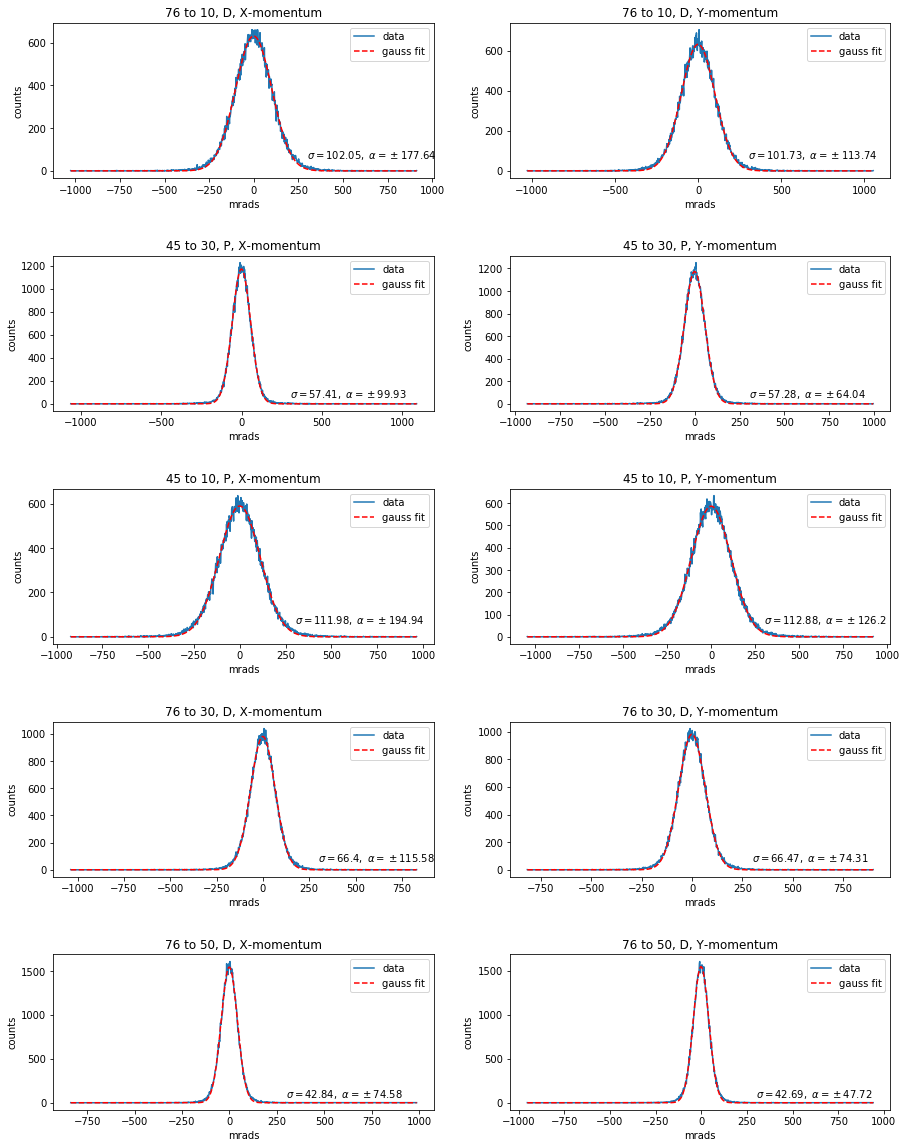

In [10]:
combinations = df1[['E_init','E_final','particle']].drop_duplicates().reset_index()

axes = df1['variable'].unique()

fig, ax = plt.subplots(len(combinations),2, figsize = (15,20))
plt.subplots_adjust(hspace = 0.5)

for col, dim in enumerate(axes):
    for row in range(0,len(combinations)):
        E_init = combinations.loc[row].E_init
        E_final = combinations.loc[row].E_final
        particle = combinations.loc[row].particle

        df_test = df1[(df1['E_init'] == E_init) & 
                      (df1['E_final'] == E_final) & 
                      (df1['particle'] == particle) &
                      (df1['variable'] == dim)
                     ]

        popt, pcov = curve_fit(gaussian, df_test['mrads'], df_test['counts'])


        ax[row,col].plot(df_test['mrads'],df_test['counts'])
        ax[row,col].plot(df_test['mrads'], gaussian(df_test['mrads'], *popt), 'r--')
        ax[row,col].legend(('data','gauss fit'))
        ax[row,col].set_xlabel('mrads')
        ax[row,col].set_ylabel('counts')
        

        sigma = np.sqrt(popt[1])
        alpha = np.sqrt(beta[dim] * popt[1] / eps[dim] -1)
        ax[row,col].text(300,60,r'$\sigma = {},\ \alpha = \pm{}$'.format(round(sigma,2),round(alpha,2)))
        ax[row,col].set_title('{} to {}, {}, {}-momentum'.format(E_init,E_final,particle,dim))